In [1]:
import torch

from torch import nn
from torch.nn import functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
device = (
    "cuda"  # nvidia GPU
    if torch.cuda.is_available()
    else "mps"  # mac GPU
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Prepare dataset

In [3]:
train_df = pd.read_csv("data/train/train.csv")
train_df.head(5)

,filename,building,camera,height
0,photo_1_2024-02-28_19-50-55.jpg,"55.83374598606761, 37.4863818073886","55.83355618950865, 37.48563078891009",24
1,photo_2_2024-02-28_19-50-55.jpg,"55.74671515046505, 37.49455264385141","55.74689329318663, 37.49520710283597",21
2,photo_3_2024-02-28_19-50-55.jpg,"55.759007045864244, 37.71650413890229","55.758900299637965, 37.71613626315986",18
3,photo_4_2024-02-28_19-50-55.jpg,"55.781247169148855, 37.540942963066165","55.78183117969778, 37.54023985374589",18
4,photo_5_2024-02-28_19-50-55.jpg,"55.63435687287336, 37.765668872386286","55.63416610435083, 37.76433849674555",51


In [4]:
class CoordinatesTransformPipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
    @staticmethod
    def distance(x: np.ndarray, y: np.ndarray) -> float:
        """
        Great-circle distance: https://en.wikipedia.org/wiki/Great-circle_distance
        Returns distance between x and y in meters
        """
        x, y = np.radians(x), np.radians(y)
        r = 6_371_000  # meters
        delta_lambda = np.abs(x[1] - y[1])
        return np.arccos(np.sin(x[0]) * np.sin(y[0]) + 
                         np.cos(x[0]) * np.cos(y[0]) * 
                         np.cos(delta_lambda)) * r
    
    def transform(self) -> pd.DataFrame:
        coords_columns = ["building", "camera"]

        for col in coords_columns:
            self.df[col] = self.coords_transform(self.df[col])

        dists = []
        for i in range(len(self.df)):
            dists.append(self.distance(
                self.df[coords_columns[0]].iloc[i],
                self.df[coords_columns[1]].iloc[i]
            ))
        self.df["distance"] = pd.Series(dists)
        return self.df.drop(columns=coords_columns)[["filename", "distance", "height"]]
            
    
    def coords_transform(self, column: pd.Series) -> pd.Series:
        splited = column.str.split(",")
        result = []
        for i in range(len(self.df)):
            result.append(np.array(
                splited.iloc[i], 
                dtype=np.float64)
            )
        return pd.Series(result)

In [5]:
transformer = CoordinatesTransformPipeline(train_df)
train_df = transformer.transform()
train_df.head(5)

,filename,distance,height
0,photo_1_2024-02-28_19-50-55.jpg,51.428476,24
1,photo_2_2024-02-28_19-50-55.jpg,45.498280,21
2,photo_3_2024-02-28_19-50-55.jpg,25.896985,18
3,photo_4_2024-02-28_19-50-55.jpg,78.422418,18
4,photo_5_2024-02-28_19-50-55.jpg,86.155339,51


In [6]:
class BuildingDataset(torch.utils.data.Dataset):
    """
    Torch dataset
    
    Returns tuple of form: tensor_image, tensor_dist, tensor_y
    (resize image to 440x440 pixels)
    
    - tensor_image is image of shape (n_channels, height, width),
    - tensor_dist is distance between camera and building in meters,
    - tensor_y is target.
    """
    normalize_params = {
        "mean": None,
        "std": None
    }
    
    def __init__(self, folder: str, df: pd.DataFrame):
        self.df = df
        self.df[["distance", "height"]] = self.numerical_normalize(self.df[["distance", "height"]])
        self.folder = folder
        
    def __len__(self) -> int:
        return len(self.df)
    
    @staticmethod
    def image2tensor(pic: Image, device: str = None) -> torch.Tensor:
        img = torch.as_tensor(np.array(pic, copy=True), device=device, dtype=torch.float32)
        img = img.view(pic.size[1], pic.size[0], 3)
        # put it from HWC to CHW format
        img = img.permute((2, 0, 1))
        return img

    def numerical_normalize(self, data: pd.DataFrame | float | int) -> pd.DataFrame | float:
        """
        Returns normalized data.
        """
        if self.normalize_params["mean"] is None and self.normalize_params["std"] is None:
            self.normalize_params["mean"] = data.mean()
            self.normalize_params["std"] = data.std()

        data = (data - self.normalize_params["mean"]) / self.normalize_params["std"]
        return data

    def __getitem__(self, key: int) -> tuple[torch.Tensor,
                                             torch.Tensor,
                                             torch.Tensor]:
        filename = f"{self.folder}/{self.df['filename'].iloc[key]}"
        
        return (self.image2tensor(Image.open(filename), device=device)[:,:-160,130:-350],
                torch.tensor(self.df["distance"].iloc[key], device=device, dtype=torch.float32),
                torch.tensor(self.df["height"].iloc[key], device=device, dtype=torch.float32))

torch.Size([3, 440, 440]) torch.Size([]) torch.Size([])


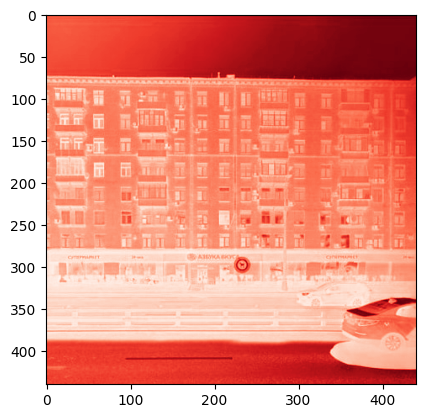

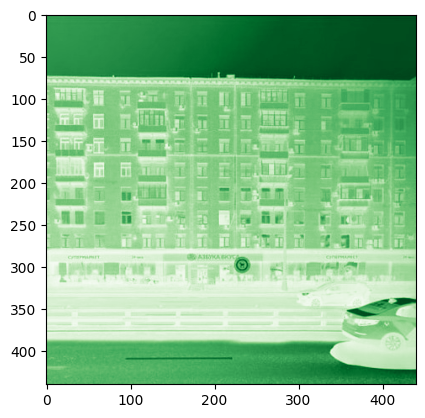

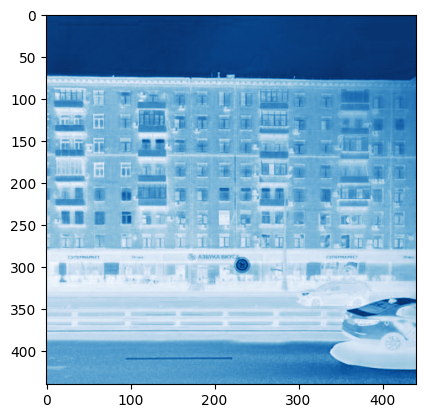

tensor(-0.3171, device='mps:0') tensor(-0.0662, device='mps:0')


In [7]:
dataset = BuildingDataset("data/train", train_df)
for image, x, y in dataset:
    print(image.shape, x.shape, y.shape)
    for channel, cm in zip(image, ["Reds", "Greens", "Blues"]):
        plt.imshow(channel.to("cpu"), cmap=cm)
        plt.show()
    print(x, y)
    break

In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, pin_memory=True)

# test batches
for i, (image, x, y) in enumerate(dataloader):
    print(f"Batch num: {i}, input: {image.shape}, {x.shape}, {y.shape}, devices: {image.device}, {x.device}, {y.device}", end="\n\n")

Batch num: 0, input: torch.Size([4, 3, 440, 440]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 1, input: torch.Size([4, 3, 440, 440]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 2, input: torch.Size([4, 3, 440, 440]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 3, input: torch.Size([4, 3, 440, 440]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 4, input: torch.Size([4, 3, 440, 440]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0



# Develop NN architecture

## Loss

In [13]:
loss = nn.L1Loss()
lr = 1e-3
epochs = 15

## Train, Test loops

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    losses = []
    
    model.train()
    for batch, (image, dist, y) in enumerate(dataloader):
        pred = model((image, dist))
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        print(f"loss: {loss:>7f}  [{batch + 1}/{size}]")
    losses = np.array(losses)

    plt.plot(np.arange(1, len(dataloader) + 1), losses, color="red")
    plt.grid()
    plt.xlabel("Batch")
    plt.ylabel("MAE")
    plt.title("Train loss")
    plt.show()


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    losses = []

    with torch.no_grad():
        for image, dist, y in dataloader:
            pred = model((image, dist))
            losses.append(loss_fn(pred, y).item())
    losses = np.array(losses)
    
    plt.plot(np.arange(1, len(dataloader) + 1), losses)
    plt.grid()
    plt.xlabel("Batch")
    plt.ylabel("MAE")
    plt.title("Test loss")
    plt.show()

    print(f"Avg test loss: {losses.mean():>8f} \n")

## AlexNet

In [65]:
from networks import AlexNet


alexnet = AlexNet().to(device)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=lr)

Epoch 1
-------------------------------
loss: 0.662372  [1/5]
loss: 0.352861  [2/5]
loss: 1.416740  [3/5]
loss: 0.624194  [4/5]
loss: 0.833885  [5/5]


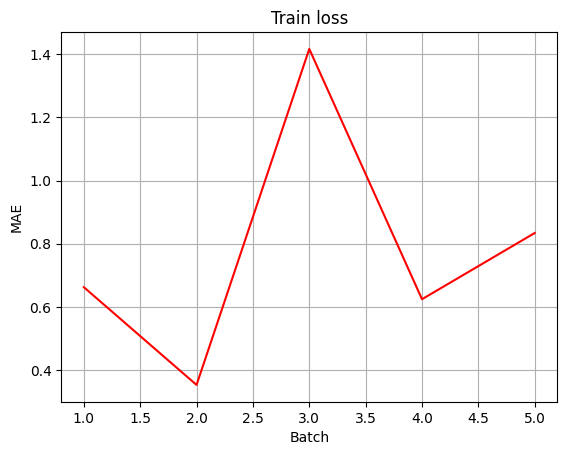

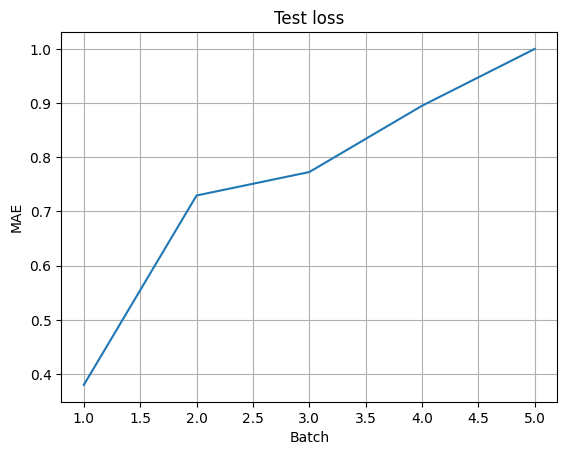

Avg test loss: 0.755468 

Epoch 2
-------------------------------
loss: 0.704671  [1/5]
loss: 0.662372  [2/5]
loss: 1.048755  [3/5]
loss: 0.558379  [4/5]
loss: 0.797310  [5/5]


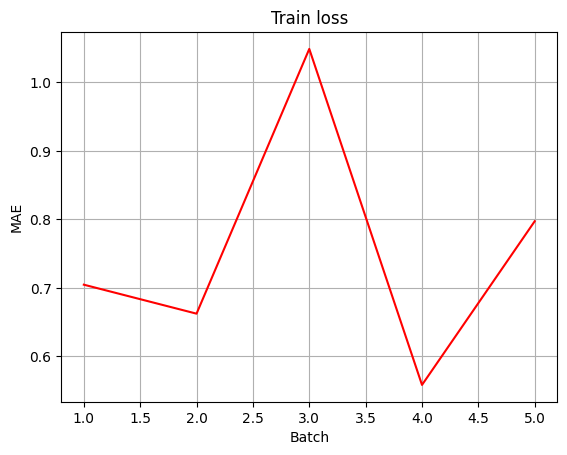

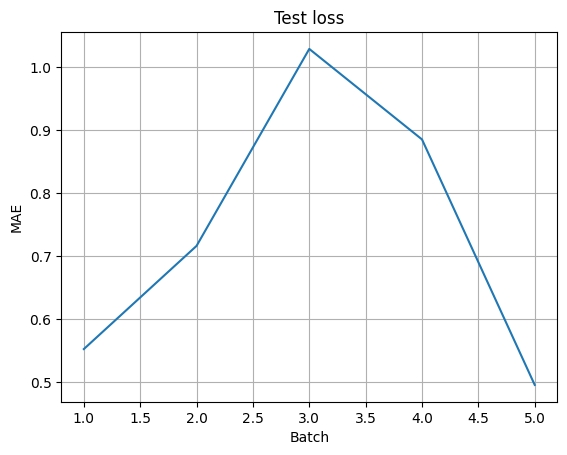

Avg test loss: 0.735277 

Epoch 3
-------------------------------
loss: 1.068885  [1/5]
loss: 0.607174  [2/5]
loss: 0.616757  [3/5]
loss: 0.813469  [4/5]
loss: 0.529763  [5/5]


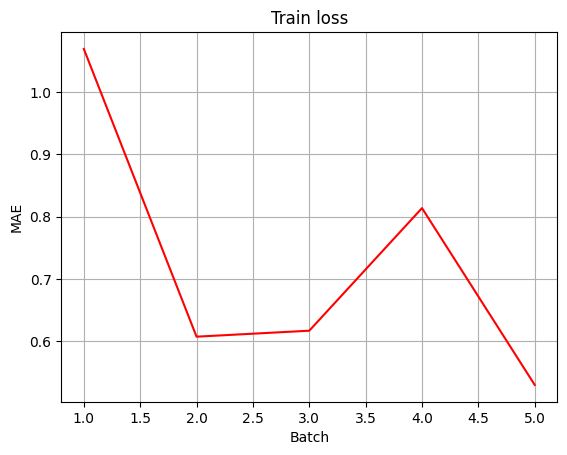

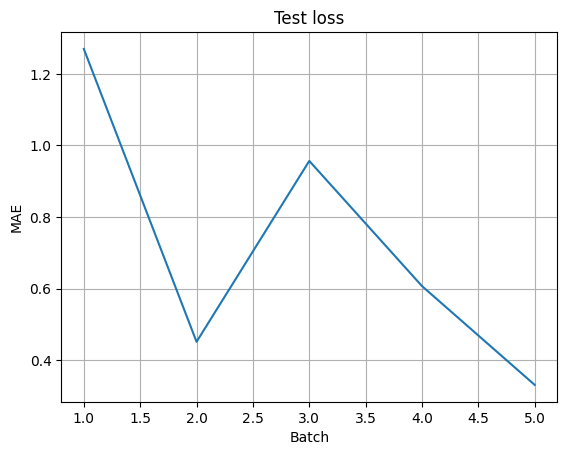

Avg test loss: 0.723246 

Epoch 4
-------------------------------
loss: 0.796157  [1/5]
loss: 0.416784  [2/5]
loss: 0.994714  [3/5]
loss: 0.551977  [4/5]
loss: 0.846364  [5/5]


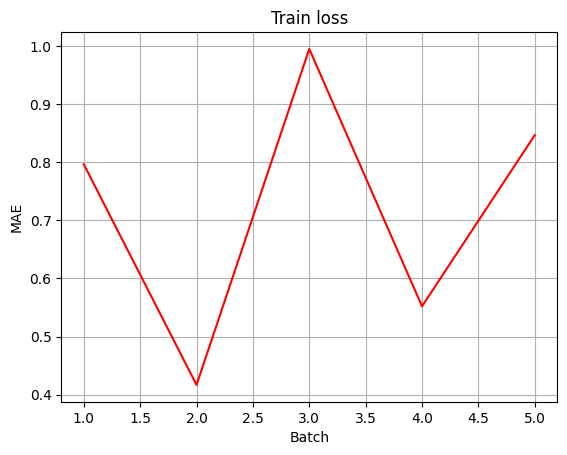

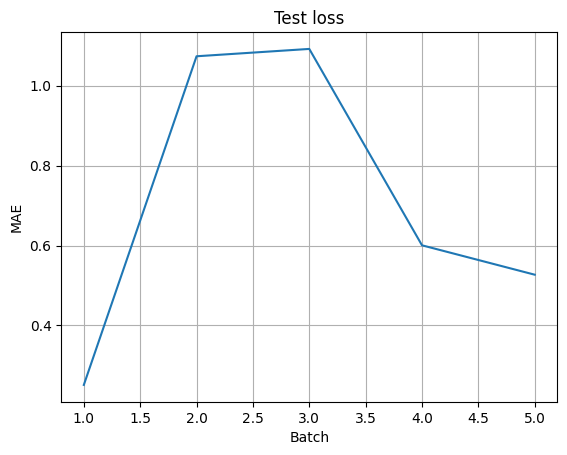

Avg test loss: 0.708873 

Epoch 5
-------------------------------
loss: 1.103953  [1/5]
loss: 0.575269  [2/5]
loss: 0.165593  [3/5]
loss: 0.496779  [4/5]
loss: 1.195949  [5/5]


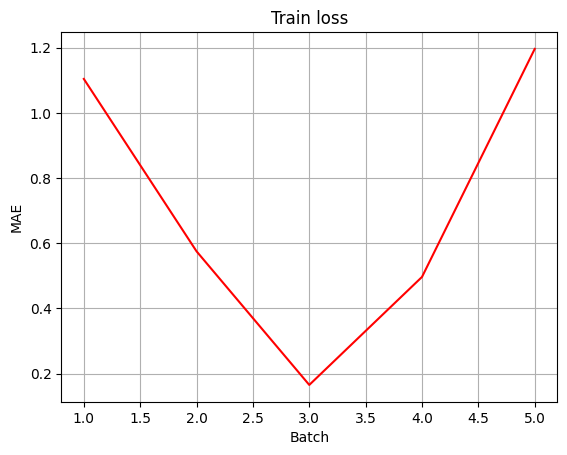

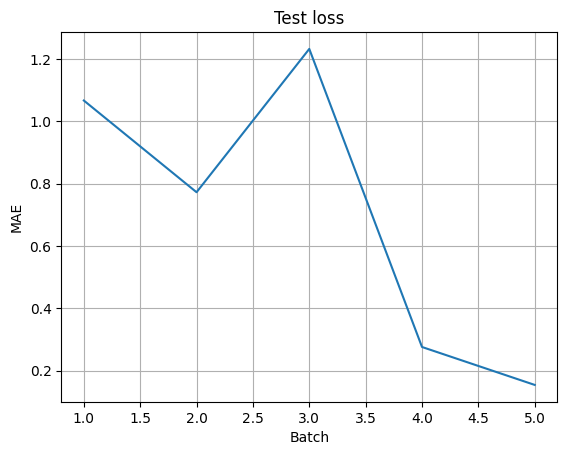

Avg test loss: 0.700581 

Epoch 6
-------------------------------
loss: 0.853418  [1/5]
loss: 0.772767  [2/5]
loss: 0.827965  [3/5]
loss: 0.399324  [4/5]
loss: 0.662610  [5/5]


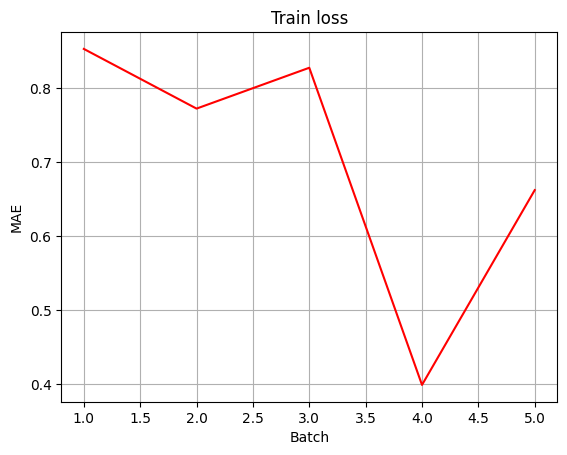

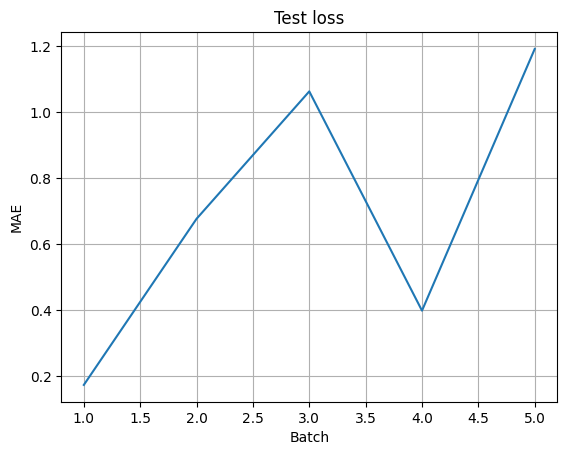

Avg test loss: 0.700176 

Epoch 7
-------------------------------
loss: 0.724541  [1/5]
loss: 0.623437  [2/5]
loss: 0.498944  [3/5]
loss: 1.140752  [4/5]
loss: 0.496779  [5/5]


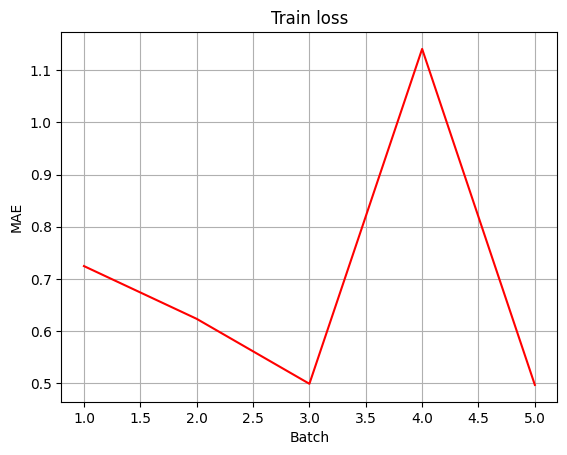

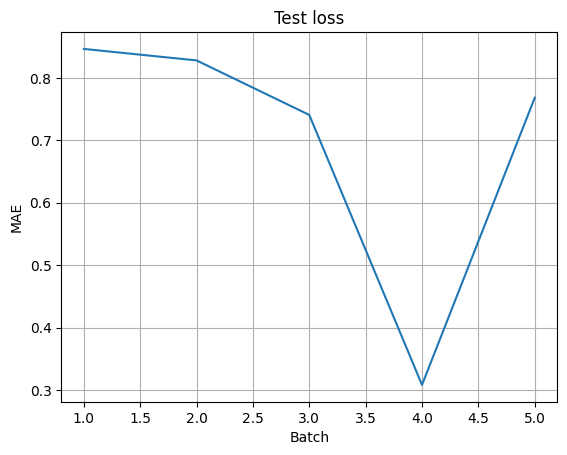

Avg test loss: 0.698241 

Epoch 8
-------------------------------
loss: 0.294388  [1/5]
loss: 1.302282  [2/5]
loss: 0.662372  [3/5]
loss: 0.723008  [4/5]
loss: 0.562884  [5/5]


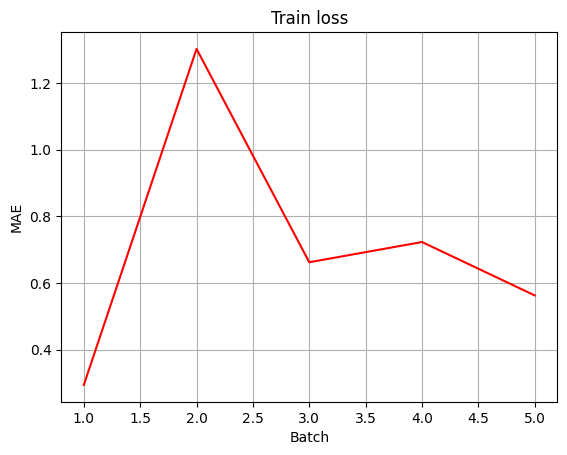

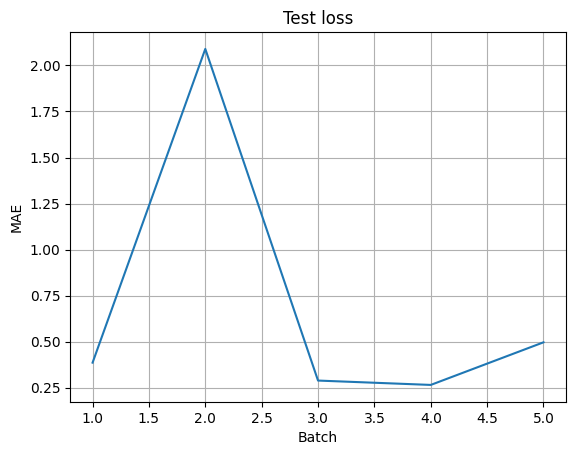

Avg test loss: 0.705483 

Done!


In [66]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(dataloader, alexnet, loss, optimizer)
    test_loop(dataloader, alexnet, loss)
print("Done!")

## ResNet34

In [14]:
from networks import ResNet34


resnet34 = ResNet34().to(device)
optimizer = torch.optim.Adam(resnet34.parameters(), lr=lr)

Epoch 1
-------------------------------
loss: 1.122352  [1/5]
loss: 0.828243  [2/5]
loss: 0.699840  [3/5]
loss: 0.993558  [4/5]
loss: 1.091032  [5/5]


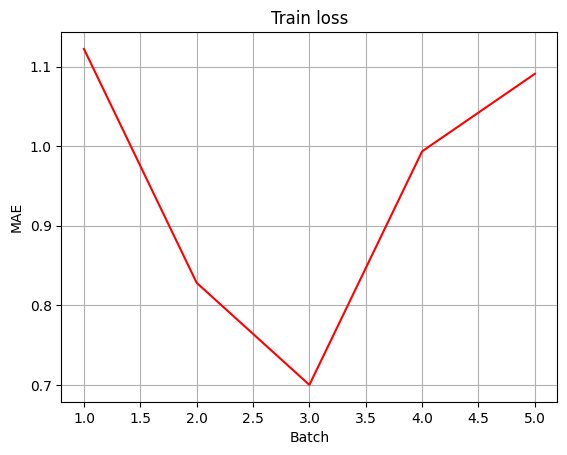

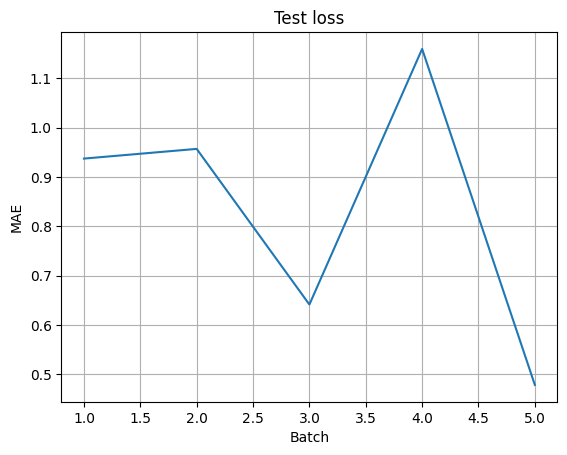

Avg test loss: 0.834710 

Epoch 2
-------------------------------
loss: 0.529884  [1/5]
loss: 0.483800  [2/5]
loss: 0.609543  [3/5]
loss: 0.857881  [4/5]
loss: 1.214225  [5/5]


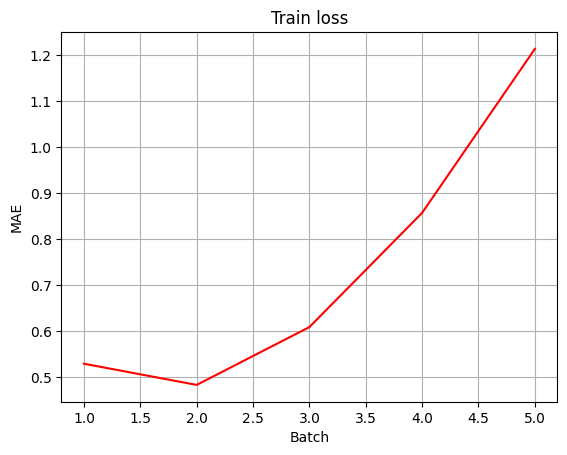

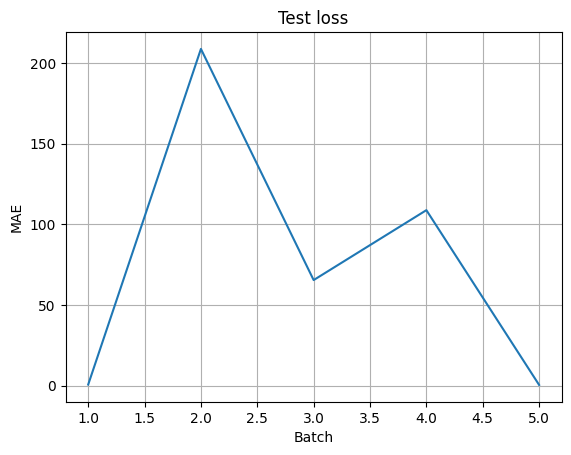

Avg test loss: 76.818727 

Epoch 3
-------------------------------
loss: 0.697308  [1/5]
loss: 0.624249  [2/5]
loss: 1.287945  [3/5]
loss: 0.607174  [4/5]
loss: 0.551977  [5/5]


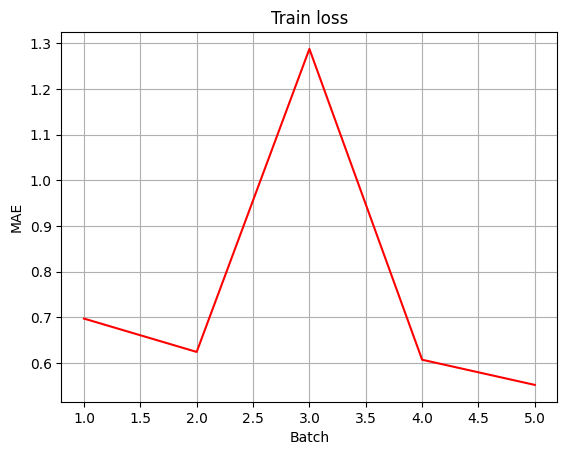

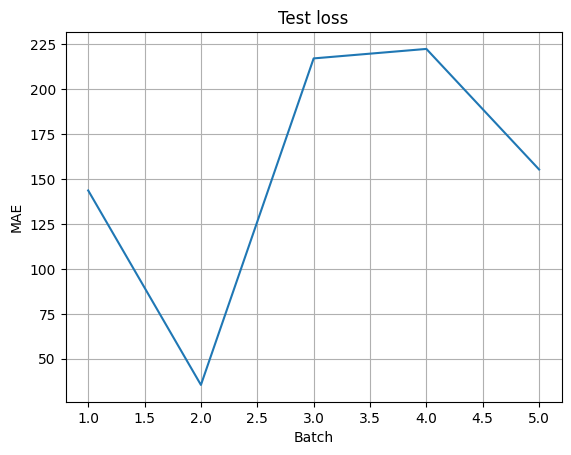

Avg test loss: 154.829287 

Epoch 4
-------------------------------
loss: 0.792516  [1/5]
loss: 0.737554  [2/5]
loss: 0.556257  [3/5]
loss: 1.070552  [4/5]
loss: 0.581605  [5/5]


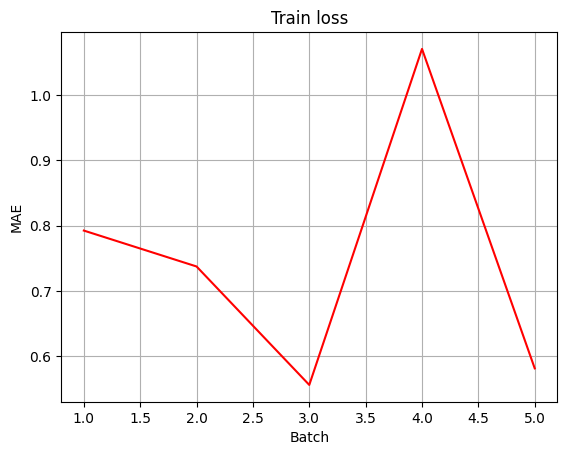

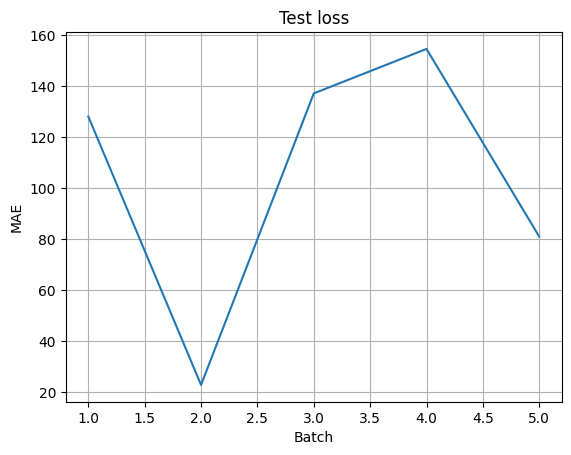

Avg test loss: 104.749287 

Epoch 5
-------------------------------
loss: 0.480105  [1/5]
loss: 0.249351  [2/5]
loss: 0.492324  [3/5]
loss: 0.889048  [4/5]
loss: 1.705393  [5/5]


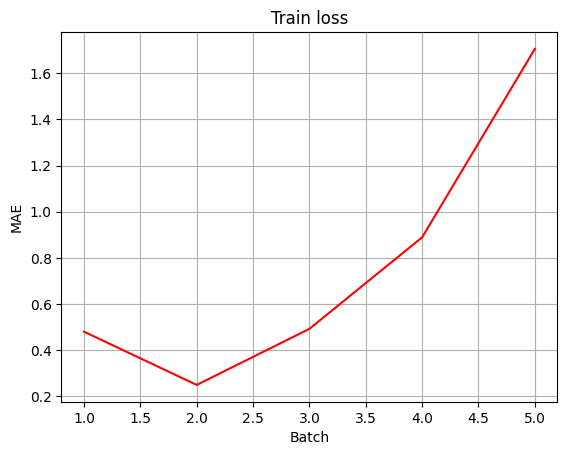

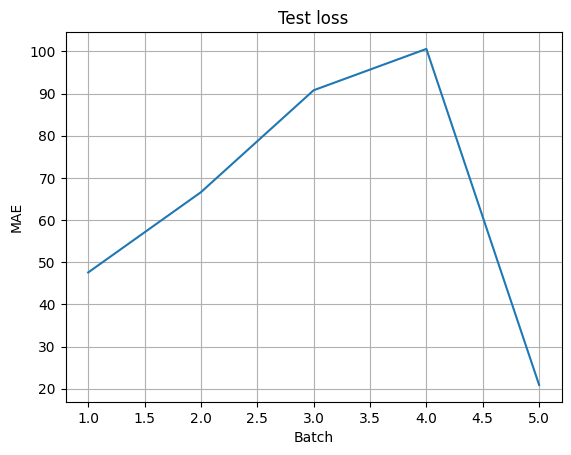

Avg test loss: 65.291611 

Epoch 6
-------------------------------
loss: 0.864739  [1/5]
loss: 1.054191  [2/5]
loss: 0.662520  [3/5]
loss: 0.758023  [4/5]
loss: 0.414628  [5/5]


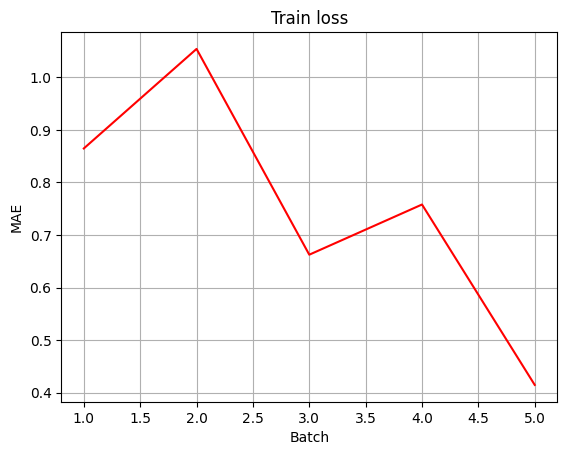

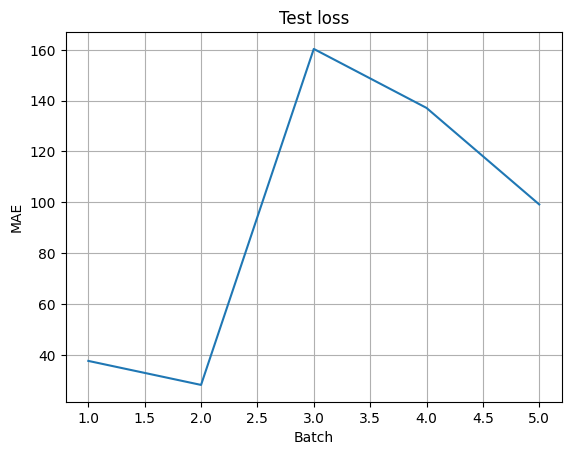

Avg test loss: 92.485221 

Epoch 7
-------------------------------
loss: 1.258488  [1/5]
loss: 0.316511  [2/5]
loss: 0.486604  [3/5]
loss: 1.254096  [4/5]
loss: 0.302737  [5/5]


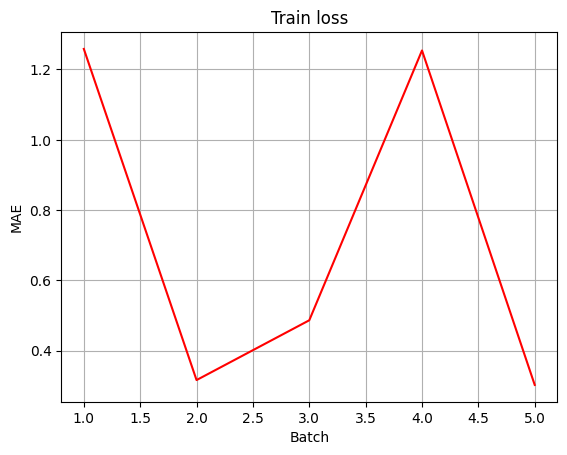

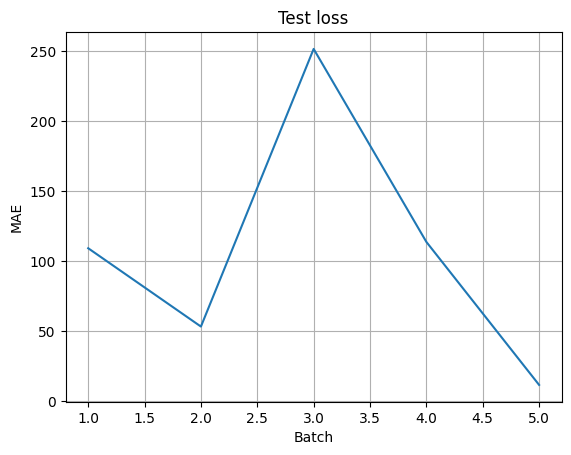

Avg test loss: 108.014103 

Epoch 8
-------------------------------
loss: 1.008904  [1/5]
loss: 0.518058  [2/5]
loss: 0.241016  [3/5]
loss: 0.301116  [4/5]
loss: 1.512692  [5/5]


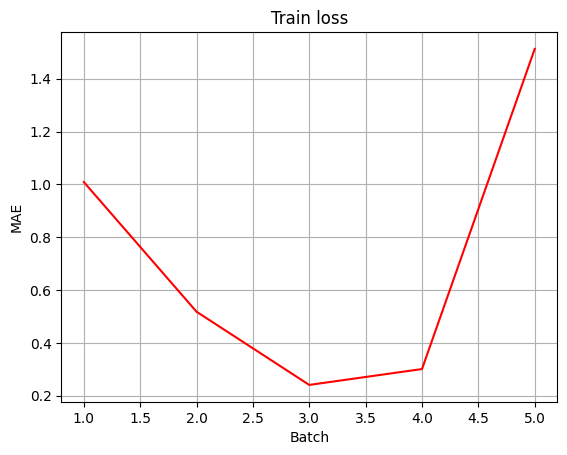

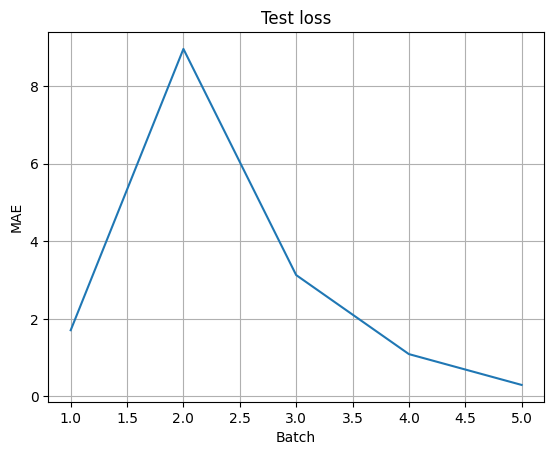

Avg test loss: 3.036061 

Epoch 9
-------------------------------
loss: 0.334564  [1/5]
loss: 0.853351  [2/5]
loss: 0.901562  [3/5]
loss: 0.660128  [4/5]
loss: 0.779427  [5/5]


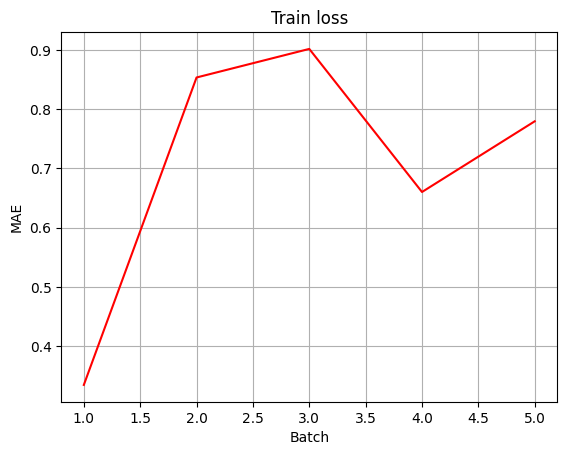

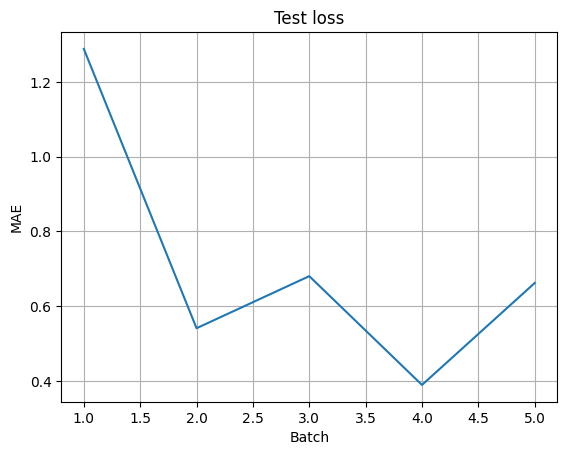

Avg test loss: 0.712450 

Epoch 10
-------------------------------
loss: 1.199268  [1/5]
loss: 0.717570  [2/5]
loss: 0.276153  [3/5]
loss: 0.505680  [4/5]
loss: 0.993558  [5/5]


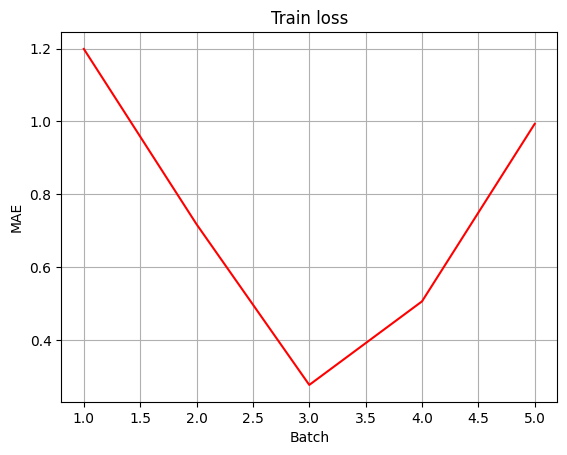

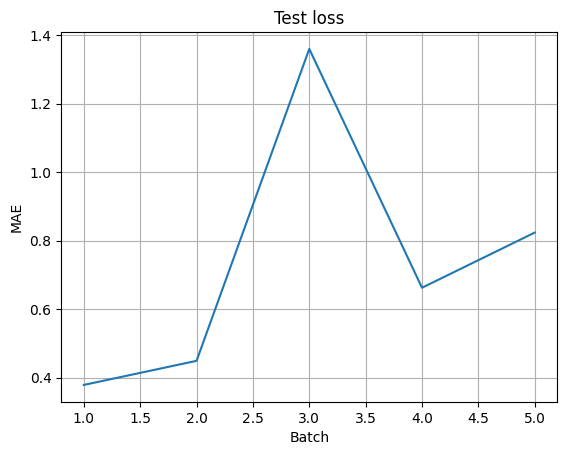

Avg test loss: 0.734650 

Epoch 11
-------------------------------
loss: 1.343143  [1/5]
loss: 0.275988  [2/5]
loss: 0.697397  [3/5]
loss: 0.901562  [4/5]
loss: 0.430810  [5/5]


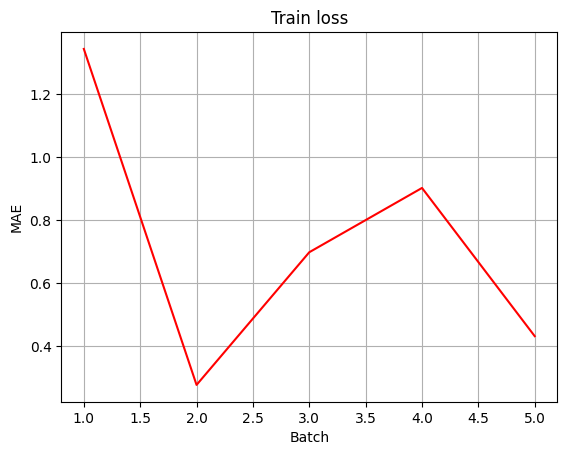

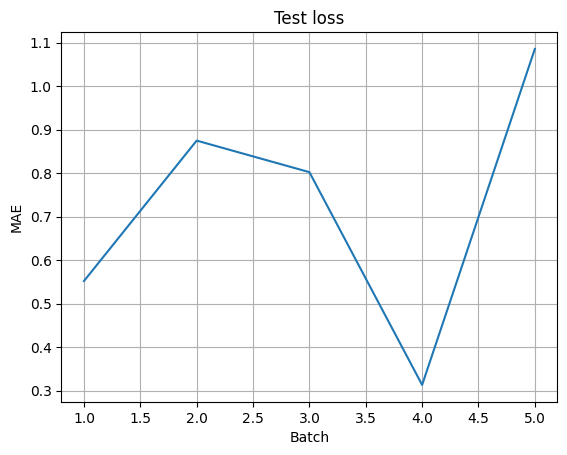

Avg test loss: 0.725525 

Epoch 12
-------------------------------
loss: 0.226376  [1/5]
loss: 0.938360  [2/5]
loss: 0.865283  [3/5]
loss: 0.833518  [4/5]
loss: 0.717570  [5/5]


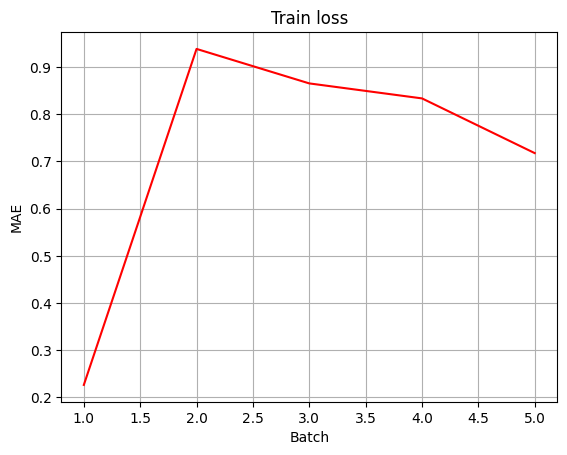

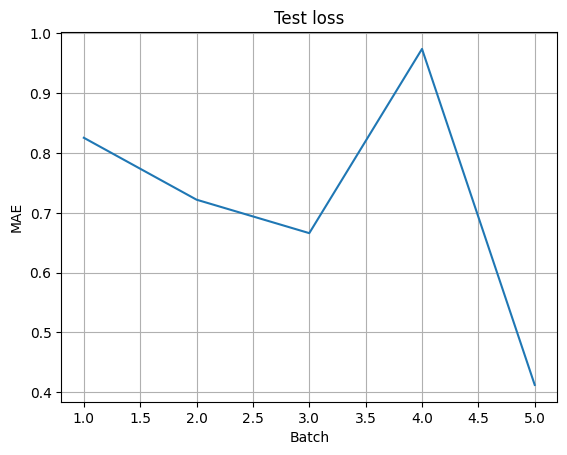

Avg test loss: 0.719924 

Epoch 13
-------------------------------
loss: 0.565048  [1/5]
loss: 1.232748  [2/5]
loss: 0.345387  [3/5]
loss: 0.896268  [4/5]
loss: 0.551977  [5/5]


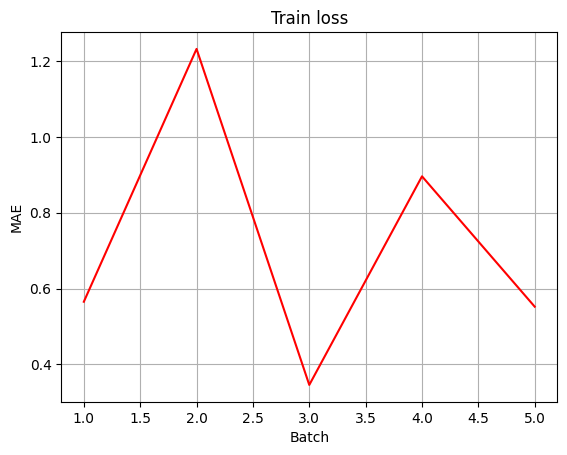

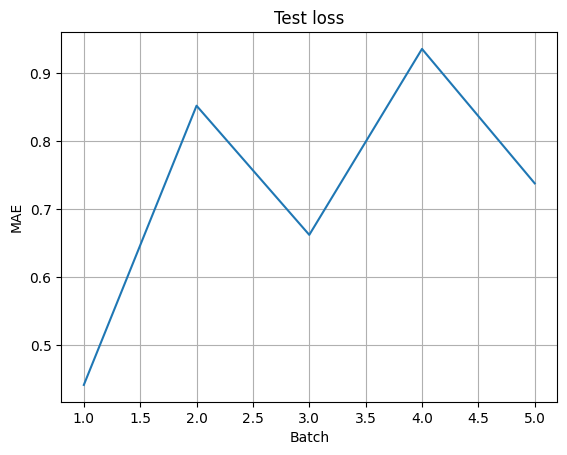

Avg test loss: 0.726042 

Epoch 14
-------------------------------
loss: 0.551977  [1/5]
loss: 1.140624  [2/5]
loss: 0.505881  [3/5]
loss: 0.607636  [4/5]
loss: 0.717570  [5/5]


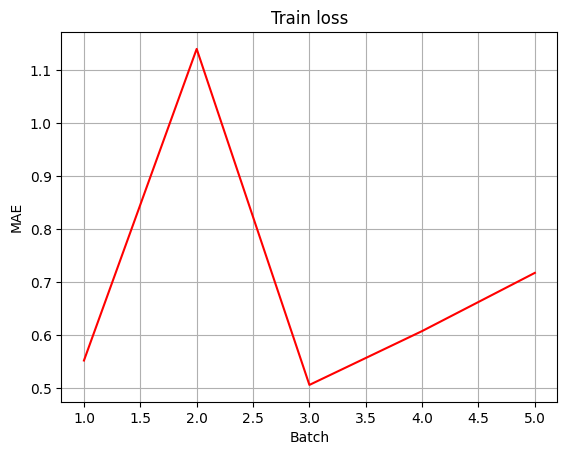

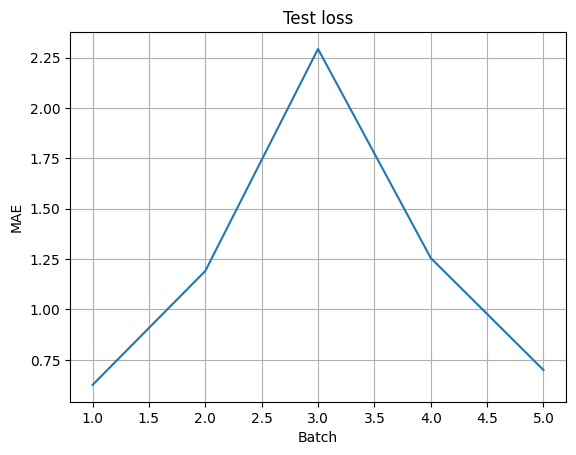

Avg test loss: 1.212934 

Epoch 15
-------------------------------
loss: 0.877204  [1/5]
loss: 0.672830  [2/5]
loss: 0.673517  [3/5]
loss: 0.625573  [4/5]
loss: 0.705453  [5/5]


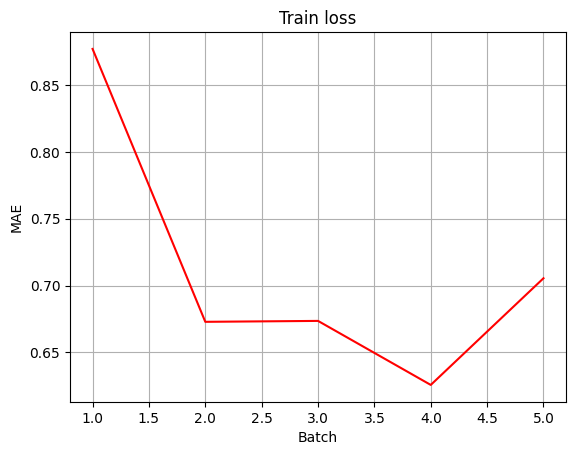

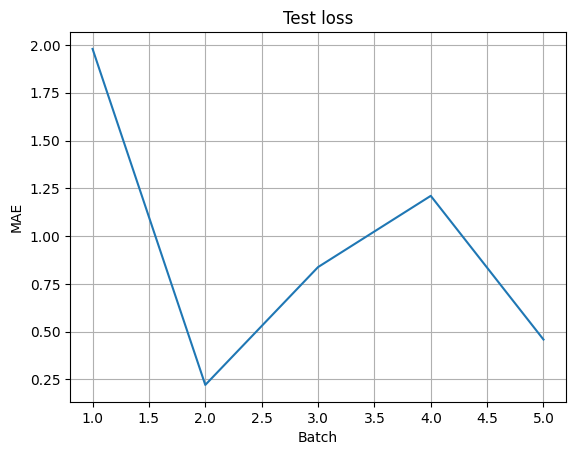

Avg test loss: 0.941291 

Done!


In [15]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(dataloader, resnet34, loss, optimizer)
    test_loop(dataloader, resnet34, loss)
print("Done!")